In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

%matplotlib inline

In [49]:
def get_data():
    tmp = pd.read_csv('../data/Overall Data.csv',skiprows=[0])
    return tmp

def plot_hist(data,features=[]):
    """
    Function for plotting the histogram for numerical features. 
    Args:
        data(pandas dataframe, required): [data(only numerical features will be plotted) for which histogram will be plotted]
        features(optional): name of the features for which histogram will be pltted --> It should be numerical features 
    """
    if len(features)==0:
        data.hist(bins=50,figsize=(20,10))
    else:
        data[features].hist(bins=50,figsize=(10,5)) 

def strata_train_test(data, ratio=0.2, strata_col = 'strata_col'):
    """
    Funtion for splitting the dataset into train and test using stratified split.
    Args:
        data (pandas dataFrame, required): [data that will be converted into train and test]
        ratio (float, optional): [test ratio]. Defaults to 0.2.
        strata_col(str, default = 'strata_col'). column name to be used for stratified sampling.
    """
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in split.split(data,data[strata_col]):
        strata_train = data.iloc[train_idx]
        strata_test = data.iloc[test_idx]
    return strata_train, strata_test 

def split_train_test(data, ratio=0.2):
    """
    Funtion for splitting the dataset into train and test.
    Args:
        data (pandas dataFrame, required): [data that will be converted into train and test]
        ratio (float, optional): [test ratio]. Defaults to 0.2.
    """
    np.random.seed(39)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def get_xgb_model(): 
    """
    Function for getting the model with parameter dictionary.. It can contain parameters like verbosity, max_depth, eta, n_estimators     etc..
    """
    return xgb.XGBRegressor(learning_rate = 0.02, max_depth=5, n_estimators = 100, verbosity=3 )


def plot_predictions_vs_length(length, labels_actual, labels_predicted):

    plt.figure(figsize=(20,10))
    plt.plot(range(length),labels_actual,'g', label='actual')
    plt.plot(range(length),labels_predicted,'r', label='predicted')
    plt.title('predicted/actual vs length')
    plt.xlabel('dataset length')
    plt.ylabel('predictins/actual values')
    plt.legend()
    plt.grid(True,color='k')
    plt.show()

features = ['total_duration','actual_prize','num_open_tasks','avg_similarity']
label = ['task_failure_probability']

In [3]:
data = get_data()
data.head()

In [5]:
data.describe()

Project Id  total_duration  actual_prize  num_open_tasks  \
count  3.756000e+03     3756.000000   3756.000000     3756.000000   
mean   3.004339e+07        5.126997    596.996938       67.730032   
std    2.112894e+03        4.982495    717.338016       24.637863   
min    3.003314e+07        0.019444      0.000000        5.000000   
25%    3.004205e+07        1.992708     75.000000       52.000000   
50%    3.004365e+07        4.943750    250.000000       66.000000   
75%    3.004502e+07        6.000000   1000.000000       85.000000   
max    3.004656e+07       48.445833   5500.000000      124.000000   

       avg_similarity  task_failure_probability        today     tomorrow  \
count     3756.000000               3756.000000  3756.000000  3756.000000   
mean         0.823966                  0.752617     0.831314     0.845387   
std          0.092241                  0.208020     0.094407     0.072007   
min          0.299937                  0.071429     0.513474     0.546537   
25%          0.772151                  0.625000     0.768947     0.797057   
50%          0.839762                  0.800000     0.832463     0.847379   
75%          0.896832                  0.916667     0.893163     0.894005   
max          0.979798                  1.000000     1.157290     1.084247   

       day after tomorrow  
count         3756.000000  
mean             0.845639  
std              0.070736  
min              0.556530  
25%              0.798618  
50%              0.845163  
75%              0.892798  
max              1.096467

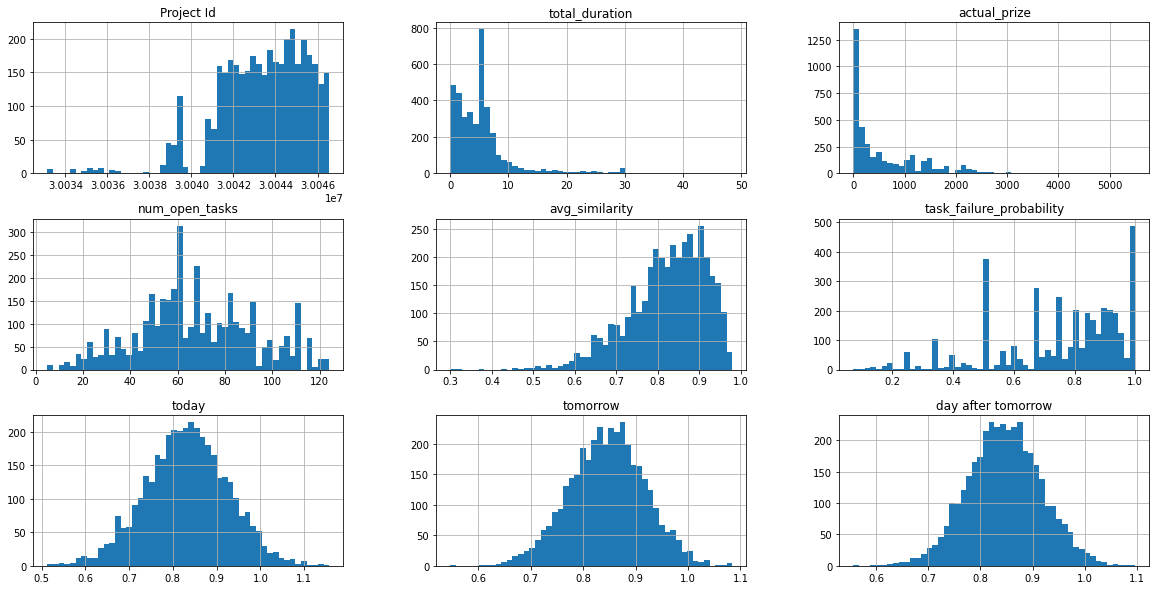

In [6]:
plot_hist(data=data)

In [7]:
data['avg_sim_strata'] = pd.cut(data['avg_similarity'],bins=[0.,0.7,0.8,0.9,1.0],labels=[1,2,3,4])
data['avg_sim_strata'].hist()

In [8]:
train, test = strata_train_test(data=data,strata_col='avg_sim_strata')
test['avg_sim_strata'].value_counts()/len(test)

3    0.416223
2    0.247340
4    0.230053
1    0.106383
Name: avg_sim_strata, dtype: float64

In [9]:
for _ in (train,test):
    _.drop(inplace=True,columns=['avg_sim_strata'])

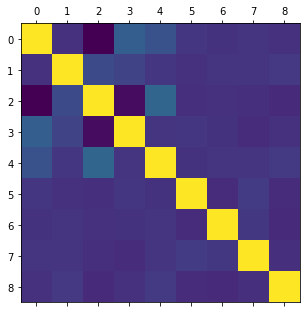

In [10]:
corr = data.corr()
f = plt.figure(figsize=(5, 5))
plt.matshow(corr,fignum=f.number)

In [11]:
corr['task_failure_probability'].sort_values(ascending=False)

task_failure_probability    1.000000
tomorrow                    0.033015
num_open_tasks              0.016285
Project Id                  0.013541
avg_similarity              0.000070
total_duration             -0.003217
actual_prize               -0.011132
day after tomorrow         -0.018705
today                      -0.021413
Name: task_failure_probability, dtype: float64

array([[<AxesSubplot:xlabel='actual_prize', ylabel='actual_prize'>,
        <AxesSubplot:xlabel='num_open_tasks', ylabel='actual_prize'>,
        <AxesSubplot:xlabel='avg_similarity', ylabel='actual_prize'>,
        <AxesSubplot:xlabel='task_failure_probability', ylabel='actual_prize'>],
       [<AxesSubplot:xlabel='actual_prize', ylabel='num_open_tasks'>,
        <AxesSubplot:xlabel='num_open_tasks', ylabel='num_open_tasks'>,
        <AxesSubplot:xlabel='avg_similarity', ylabel='num_open_tasks'>,
        <AxesSubplot:xlabel='task_failure_probability', ylabel='num_open_tasks'>],
       [<AxesSubplot:xlabel='actual_prize', ylabel='avg_similarity'>,
        <AxesSubplot:xlabel='num_open_tasks', ylabel='avg_similarity'>,
        <AxesSubplot:xlabel='avg_similarity', ylabel='avg_similarity'>,
        <AxesSubplot:xlabel='task_failure_probability', ylabel='avg_similarity'>],
       [<AxesSubplot:xlabel='actual_prize', ylabel='task_failure_probability'>,
        <AxesSubplot:xlabel='num_open

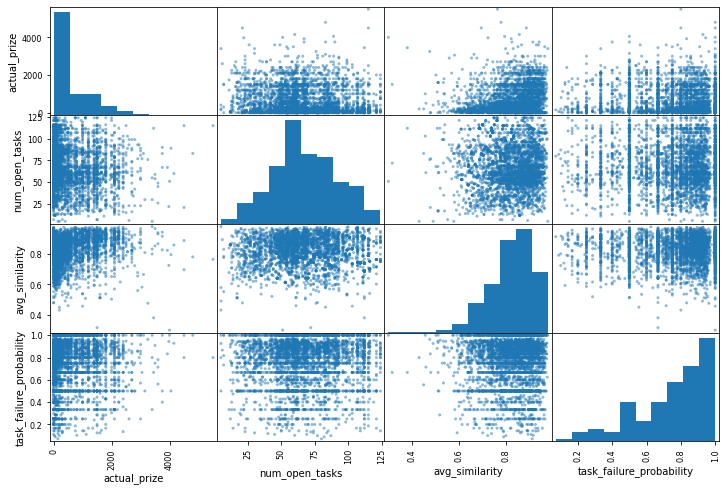

In [12]:
from pandas.plotting import scatter_matrix
attr = ['actual_prize','num_open_tasks','avg_similarity','task_failure_probability']
scatter_matrix(data[attr],figsize=(12,8))

In [13]:
data.isna().sum()

Project Id                  0
total_duration              0
actual_prize                0
num_open_tasks              0
avg_similarity              0
task_failure_probability    0
today                       0
tomorrow                    0
day after tomorrow          0
avg_sim_strata              0
dtype: int64

In [14]:
train.head()

Project Id  total_duration  actual_prize  num_open_tasks  \
2553    30044670        4.000694         800.0              62   
389     30040970        4.999306        1400.0              60   
777     30041779       16.220139        1000.0              95   
1264    30042618        0.634028         125.0              67   
1971    30043795        8.704167         200.0             116   

      avg_similarity  task_failure_probability     today  tomorrow  \
2553        0.886587                  0.625000  0.781988  0.877014   
389         0.796881                  0.962963  0.809928  0.777051   
777         0.760686                  0.400000  0.970372  0.775306   
1264        0.775424                  0.500000  0.994956  0.793623   
1971        0.751682                  0.857143  0.646922  0.797554   

      day after tomorrow  
2553            0.787718  
389             0.798566  
777             0.733706  
1264            0.820872  
1971            0.847134

In [15]:
train.describe()

Project Id  total_duration  actual_prize  num_open_tasks  \
count  3.004000e+03     3004.000000    3004.00000     3004.000000   
mean   3.004336e+07        5.114028     600.23968       67.987683   
std    2.117552e+03        4.960724     722.86244       24.673874   
min    3.003314e+07        0.019444       0.00000        5.000000   
25%    3.004200e+07        1.992708      75.00000       52.000000   
50%    3.004358e+07        4.946875     250.00000       66.000000   
75%    3.004498e+07        6.000000    1000.00000       85.000000   
max    3.004656e+07       47.244444    5500.00000      124.000000   

       avg_similarity  task_failure_probability        today     tomorrow  \
count     3004.000000               3004.000000  3004.000000  3004.000000   
mean         0.823965                  0.753048     0.831273     0.845684   
std          0.092603                  0.207297     0.093691     0.072326   
min          0.299937                  0.088235     0.522405     0.610825   
25%          0.772355                  0.631579     0.769877     0.795777   
50%          0.839893                  0.800000     0.832498     0.847337   
75%          0.896891                  0.916667     0.893782     0.894953   
max          0.979798                  1.000000     1.143841     1.078733   

       day after tomorrow  
count         3004.000000  
mean             0.845886  
std              0.071176  
min              0.556530  
25%              0.798862  
50%              0.844938  
75%              0.893550  
max              1.096467

In [16]:
train_train, train_val = split_train_test(train)

In [17]:
import xgboost as xgb

In [19]:
model = get_xgb_model()
model.fit(train_train[features],train_train[label],eval_set=[(train_val[features],train_val[label])],early_stopping_rounds=3,eval_metric='rmse')

ax_depth=5
[3]	validation_0-rmse:0.31283
[14:39:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[4]	validation_0-rmse:0.30941
[14:39:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[5]	validation_0-rmse:0.30606
[14:39:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[6]	validation_0-rmse:0.30282
[14:39:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[7]	validation_0-rmse:0.29967
[14:39:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nod

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=3)

In [20]:
predict = model.predict(train_train[features])

In [53]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=3)

In [21]:
D = pd.DataFrame()
D['actual'] = train_train['task_failure_probability']
D['predict'] = predict 
D['today'] = train_train['today']

In [22]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, train[features], train[label], scoring='neg_mean_squared_error', cv=10)

:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:40:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:40:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[14:40:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[14:40:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:40:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned

In [23]:
np.sqrt(-scores)

array([0.21416107, 0.21499524, 0.20860157, 0.21066652, 0.20846624,
       0.20830862, 0.20294976, 0.20343775, 0.21603539, 0.23019967])

In [24]:
np.sqrt(-scores).mean()

0.21178218292084128

In [25]:
np.sqrt(-scores).std()

0.007452112146140522

In [26]:
predict_val = model.predict(train_val[features])
E = pd.DataFrame()
E['actual'] = train_val['task_failure_probability']
E['predict'] = predict_val
E['today'] = train_val['today']

In [27]:
model.predict(train_val[features])

array([0.7580172 , 0.72116184, 0.73132575, 0.74592674, 0.72102594,
       0.7231035 , 0.7131479 , 0.7152865 , 0.7503671 , 0.722331  ,
       0.7095937 , 0.6528446 , 0.7346538 , 0.72285557, 0.7144338 ,
       0.687946  , 0.72883046, 0.74693286, 0.69807464, 0.7318275 ,
       0.64987236, 0.6998077 , 0.7183208 , 0.7257    , 0.7186299 ,
       0.7145147 , 0.7126815 , 0.7026364 , 0.71340495, 0.7267783 ,
       0.72734606, 0.7215774 , 0.7148678 , 0.7212134 , 0.74068177,
       0.7511983 , 0.7002599 , 0.72325194, 0.6960785 , 0.68364286,
       0.71651345, 0.6992336 , 0.7187811 , 0.7196956 , 0.72531974,
       0.6717619 , 0.7501753 , 0.7078324 , 0.75438637, 0.73114175,
       0.73561984, 0.72570825, 0.6855663 , 0.7234047 , 0.72809577,
       0.7067779 , 0.7710965 , 0.72168016, 0.7302074 , 0.72102594,
       0.72448456, 0.7552533 , 0.7189991 , 0.7316879 , 0.71999514,
       0.7401492 , 0.70765525, 0.6902829 , 0.73542804, 0.7178053 ,
       0.72830176, 0.7441666 , 0.72518235, 0.7103015 , 0.70859

In [29]:
from sklearn.metrics import mean_squared_error 
rmse_neural = mean_squared_error(E['actual'], E['today'], squared=False)
rmse_xg = mean_squared_error(E['actual'], E['predict'], squared=False)

In [30]:
rmse_neural,rmse_xg

(0.23966568101697222, 0.21027540718495027)

In [31]:
F = pd.DataFrame()
F['actual'] = test['task_failure_probability']
F['pred_xg'] = model.predict(test[features])
F['pred_neural'] = test['today']

In [32]:
rmse_test_neural = mean_squared_error(F['actual'], F['pred_neural'], squared=False)
rmse_test_xg = mean_squared_error(F['actual'], F['pred_xg'], squared=False)

In [33]:
rmse_test_neural,rmse_test_xg

(0.2464921012970353, 0.21441766273837043)

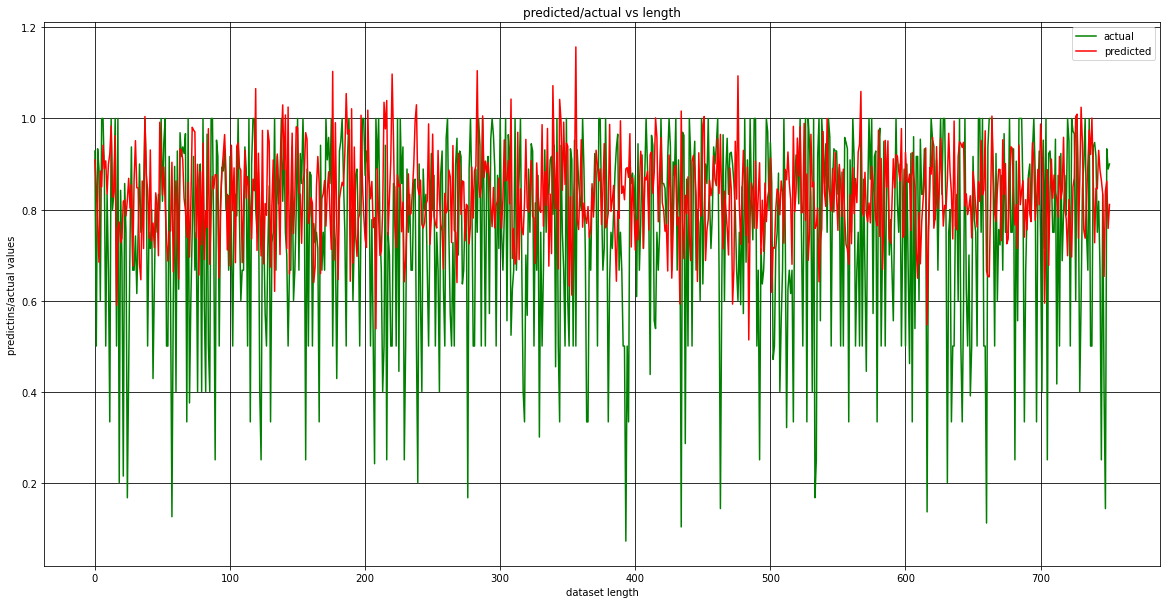

In [50]:
# plt.plot(range(len(test)),F['actual'],'g')
# plt.plot(range(len(test)),F['pred_neural'],'c')
# plt.show()
plot_predictions_vs_length(len(test),F['actual'],F['pred_neural'])

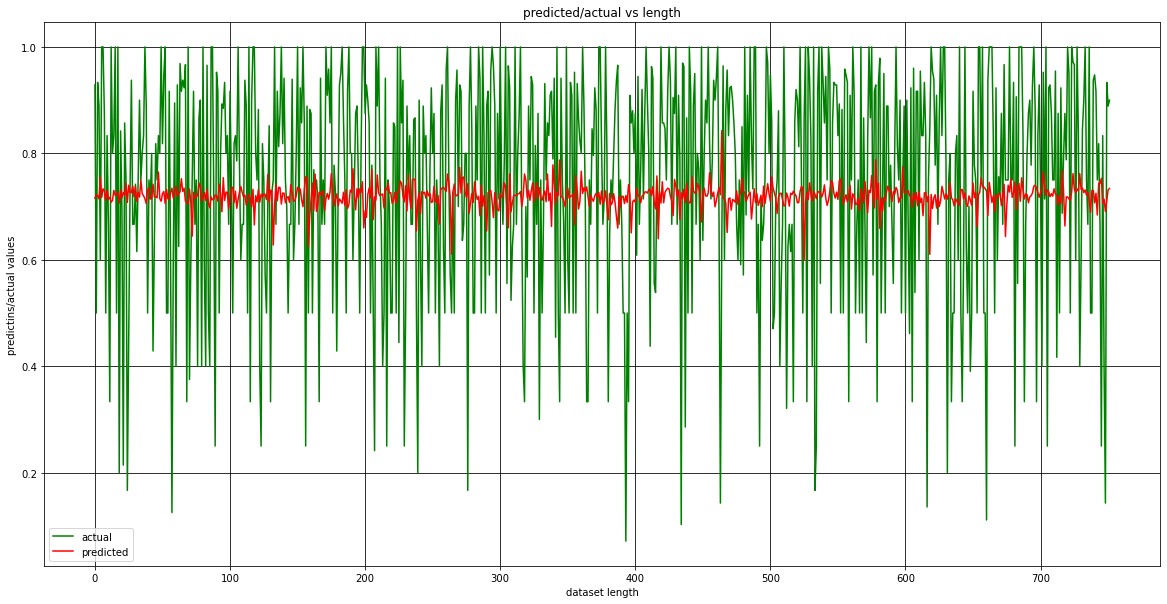

In [51]:
# plt.plot(range(len(test)),F['actual'],'g')
# plt.plot(range(len(test)),F['pred_xg'],'r')
# plt.show()
plot_predictions_vs_length(len(test),F['actual'],F['pred_xg'])

## GridSearch 

In [52]:
    from sklearn.model_selection import GridSearchCV

In [54]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=3)

In [ ]:
param_dict = {
    'learning_rate':[ 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5],
    'max_depth': [5,7,9, 10, 15],
    # 'n_estimators': [100, 150, 200, 250, 350],
    # 'colsample_bytree':[0.2,0.4,0.6,0.8,1],
    # 'colsample_bynode':[0.6,0.8,1],
    # 'min_child_weight': [5,8,10,12,14]
}
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : "rmse", 
            "eval_set" : [(train_val[features],train_val[label])]
}
grid_model = GridSearchCV(estimator = model,param_grid = param_dict, cv=10, refit = True, verbose = 3,return_train_score = True)
grid_model.fit(train_train[features],train_train[label],**fit_params)   